# Inheriting from Unit

## Layout

**A Unit subclass has class attributes that dictate how an instance is initialized:**
    
* `_F_BM_default` : dict[str, float] Default bare module factors for each purchase cost item.

* `_units` : [dict] Units of measure for the `design_results` items.

* `_N_ins`=1 : [int] Expected number of input streams.
    
* `_N_outs`=1 : [int] Expected number of output streams.
    
* `_ins_size_is_fixed`=True : [bool] Whether the number of streams in ins is fixed.
    
* `_outs_size_is_fixed`=True : [bool] Whether the number of streams in outs is fixed.

* `auxiliary_unit_names`=() : tuple[str] Name of attributes that are auxiliary units.

* `_graphics` : [biosteam Graphics] A Graphics object for diagram representation. Defaults to a box diagram.

* `_default_equipment_lifetime` : [int] or dict[str, int] Default lifetime of equipment. Defaults to lifetime of production venture.
    
* `line` : [str] Label for the unit operation in a diagram. Defaults to the class name.

**Abstract methods are used to run heat and mass balances, find design requirements, and cost the unit:**

* `_run()` : Called during System convergece to specify `outs` streams.

* `_design()` : Called after System convergence to find design requirements. 

* `_cost()` : Called after `_design` to find cost requirements.

**These abstract methods will rely on the following instance attributes:**

* `ins` : Inlets[Stream] Input streams.

* `outs` : Outlets[Stream] Output streams.

* `power_utility` : [PowerUtility] Used to add electricity rate requirement.

* `heat_utilities` : list[HeatUtility] Used to add cooling and heating requirements.

* `design_results` : [dict] All design requirements.

* `baseline_purchase_costs` : [dict] Itemized purchase costs (without accounting for design, pressure or material factors).

* `parallel` : [dict] Name-number pairs of baseline purchase costs and auxiliary unit operations in parallel.

* `F_BM`: [dict] Bare-module factors.

* `F_D`: [dict] Design factors.

* `F_P`: [dict] Pressure factors.

* `F_M`: [dict] Material factors.

* `equipment_lifetime`: [dict] Lifetime of each equiment.

* `thermo` : [Thermo] The thermodynamic property package used by the unit.

### Subclass example

The following example depicts inheritance from Unit by creating a new Boiler class:

In [1]:
import biosteam as bst
from math import ceil
bst.nbtutorial()

class Boiler(bst.Unit):
    """
    Create a Boiler object that partially boils the feed.
    
    Parameters
    ----------
    ins :
        Inlet fluid.
    outs :
        * [0] vapor product
        * [1] liquid product
    V : float
        Molar vapor fraction.
    P : float
        Operating pressure [Pa].
    
    """
    # Note that the documentation does not include `ID` or `thermo` in the parameters.
    # This is OK, and most subclasses in BioSTEAM are documented this way too.
    # Documentation for all unit operations should include the inlet and outlet streams
    # listed by index. If there is only one stream in the inlets (or outlets), there is no
    # need to list out by index. There is no need to specify the types for the `ins` and `outs` either;
    # BioSTEAM automatically adds the correct types for these when creating the documentation.
    # Any additional arguments to the unit should also be listed (e.g. V, and P).
    
    _N_ins = 1 # Number in inlets
    _N_outs = 2 # Number in outlets
    _units = {'Area': 'm^2'}
    
    def _init(self, V, P):
        # The _init methods adds input parameters for unit creation
        self.V = V #: Molar vapor fraction.
        self.P = P #: Operating pressure [Pa].
  
    def _run(self):
        # Equivalent to self.ins[0] when the number of inlets is one
        feed = self.feed 
        vap, liq = self.outs
        
        # Perform vapor-liquid equilibrium
        stream = feed.copy()
        stream.vle(V=self.V, P=self.P)
        
        # Update outlet streams
        vap.copy_like(stream['g'])
        liq.copy_like(stream['l'])
        
    def _design(self):
        # Add heat utility requirement
        T_operation = self.outs[0].T
        duty = self.H_out - self.H_in
        if duty < 0: raise RuntimeError(f'{repr(self)} is cooling.')
        heat_utility = self.add_heat_utility(duty, T_operation) # New utility is also in self.heat_utilities
        
        # Temperature of utility at entrance
        T_utility = heat_utility.inlet_utility_stream.T
        
        # Temeperature gradient
        dT = T_utility - T_operation
        
        # Heat transfer coefficient kJ/(hr*m2*K)
        U = 8176.699 
        
        # Area requirement (m^2)
        A = duty /(U * dT)
        
        # Maximum area per unit
        A_max = 743.224
        
        # Number of units
        N = ceil(A / A_max)
        
        # Design requirements (excluding utilities) are stored here
        self.design_results['Area'] = A / N
        
        # The capital cost of all boilers will be equal to the cost of a single
        # boiler by the number of boilers
        self.parallel['Boiler'] = N
        
    def _cost(self):
        A = self.design_results['Area']
        
        # Long-tube vertical boiler cost correlation from 
        # "Product process and design". Warren et. al. (2016) Table 22.32, pg 592
        purchase_cost = bst.settings.CEPCI * 3.086 * A **0.55
        
        # Itemized purchase costs are stored here
        self.baseline_purchase_costs['Boiler'] = purchase_cost # Not accounting for material factor
        
        # Assume design, pressure, and material factors are 1.
        self.F_D['Boiler'] = self.F_P['Boiler'] = self.F_M['Boiler'] = 1.
        
        # Set bare-module factor for boilers
        self.F_BM['Boiler'] = 2.45
    

### Simulation test

In [2]:
import biosteam as bst
bst.settings.set_thermo(['Water'])
water = bst.Stream('water', Water=300)
B1 = Boiler('B1', ins=water, outs=('gas', 'liq'),
            V=0.5, P=101325)
B1.diagram()
B1.show()

Boiler: B1
ins...
[0] water  
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow (kmol/hr): Water  300
outs...
[0] gas  
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow: 0
[1] liq  
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow: 0


In [3]:
B1.simulate()
B1.show()

Boiler: B1
ins...
[0] water  
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow (kmol/hr): Water  300
outs...
[0] gas  
    phase: 'g', T: 373.12 K, P: 101325 Pa
    flow (kmol/hr): Water  150
[1] liq  
    phase: 'l', T: 373.12 K, P: 101325 Pa
    flow (kmol/hr): Water  150


In [4]:
# Note that utility requirements, items in the `design_results` dictionary,
# and purchase costs are automatically included in the results dataframe.
B1.results()

Boiler                        Units       B1
Low pressure steam  Duty      kJ/hr 8.21e+06
                    Flow    kmol/hr      212
                    Cost     USD/hr     50.4
Design              Area        m^2     24.4
Purchase cost       Boiler      USD 1.02e+04
Total purchase cost             USD 1.02e+04
Utility cost                 USD/hr     50.4

In [5]:
# Note that the number of boilers are automatically accounted for 
# through the `parallel` dictionany.
B1.feed.scale(100) # Rescale flow rate x100
B1.simulate()
B1.results()

Boiler                             Units       B1
Low pressure steam  Duty           kJ/hr 8.21e+08
                    Flow         kmol/hr 2.12e+04
                    Cost          USD/hr 5.04e+03
Design              Area             m^2      610
Purchase cost       Boiler (x4)      USD 2.38e+05
Total purchase cost                  USD 2.38e+05
Utility cost                      USD/hr 5.04e+03

### Graphviz attributes

All [graphviz](https://graphviz.readthedocs.io/en/stable/manual.html) attributes for generating a diagram are stored in `_graphics` as a Graphics object. One Graphics object is generated for each Unit subclass:

In [6]:
graphics = Boiler._graphics
edge_in = graphics.edge_in
edge_out = graphics.edge_out
node = graphics.node

In [7]:
# Attributes correspond to each inlet stream respectively
# For example: Attributes for B1.ins[0] would correspond to edge_in[0]
edge_in 

[{'headport': 'c'}]

In [8]:
# Attributes correspond to each outlet stream respectively
# For example: Attributes for B1.outs[0] would correspond to edge_out[0]
edge_out

[{'tailport': 'c'}, {'tailport': 'c'}]

In [9]:
node # The node represents the actual unit

{'shape': 'box',
 'style': 'filled',
 'gradientangle': '0',
 'width': '0.6',
 'height': '0.6',
 'orientation': '0.0',
 'peripheries': '1',
 'margin': 'default',
 'fontname': 'Arial'}

These attributes can be changed to the user's liking:

In [10]:
edge_out[0]['tailport'] = 'n'
edge_out[1]['tailport'] = 's'
node['width'] = '1'
node['height'] = '1.2'

In [11]:
B1.diagram()

It is also possible to dynamically adjust node and edge attributes by setting the `tailor_node_to_unit` attribute:

In [12]:
def tailor_node_to_unit(node, unit):
    if unit.feed.isempty(): node['label'] += '\n-empty-'
graphics.tailor_node_to_unit = tailor_node_to_unit
B1.diagram()

In [13]:
B1.ins[0].empty()
B1.diagram()

NOTE: The example implementation of the `tailor_node_to_unit` function is not suggested; best to keep diagrams simple.

### Cost decorator

The cost decorator adds a free on board purchase cost based on the exponential scale up equation:

$New\ cost = N \cdot cost \bigg(\frac{CE_{new}}{CE}\bigg) \bigg(\frac{S_{new}}{N \cdot S}\bigg)^{n}$

$Electricity\ rate = kW \bigg(\frac{S_{new}}{S}\bigg)$

$N = ceil \bigg( \frac{S_{new}}{ub} \bigg)$

$N\text{: Number of units}$

$ub\text{: Upper bound of size}$

$CE_{new}\text{: New Chemical Engineering Plant Cost Index}$

$CE\text{: Chemical Engineering Plant Cost Index}$

$S_{new}\text{: New size value}$

$S\text{: Original size value}$

$cost\text{: Free on board purchase cost at size S}$

$kW\text{: Electricity rate in kW at size S}$

$n\text{: Exponential factor}$

$lifetime\text{: Number of operating years until equipment needs to be replaced}$


Create a Shredder Unit subclass for sugar cane with the following exponential scale up factors [[1]](#References):

* Chemical Engineering Plant Cost Index: 567.3
* Size: 500,000 kg/hr flow rate
* Purchase cost: $2,500,000
* Electricity rate: 3,000 kW
* Exponential factor: 0.6
* Bare module factor: 1.39
* Equipment lifetime: 30

Additionally, include a bare module factor of 1.39 as an approximation for this example [[2]](#References).

In [14]:
import biosteam as bst
from biosteam.units.decorators import cost

# Set up thermo property package
chemicals = bst.Chemicals(['Water', 'Ethanol'])
SugarCane = bst.Chemical.blank('SugarCane', phase_ref='s')
SugarCane.default()
chemicals.append(SugarCane)
bst.settings.set_thermo(chemicals)

# For year 2018
bst.CE = 603.1 

# basis will be the total flow rate in kg/hr
@cost('Flow rate', units='kg/hr', cost=2.5e6, CE=567.3,
      n=0.6, S=500e3, kW=3000, BM=1.39, lifetime=30)
class Shredder(bst.Unit): pass
# Units without a `_run` method assume one input and output stream
# that share the same flow rates and conditions

### Test a Shreadder object ###

# Display flow rate in kg/hr
bst.Stream.display_units.flow = 'kg/hr'

feed = bst.Stream(SugarCane=1e6, units='kg/hr')
shredder = Shredder(ins=feed)
shredder.simulate()

shredder.show()
shredder.results()

Shredder: U1
ins...
[0] s1  
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow (kg/hr): SugarCane  1e+06
outs...
[0] s2  
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow (kg/hr): SugarCane  1e+06


Shredder                        Units       U1
Electricity         Power          kW    6e+03
                    Cost       USD/hr      469
Design              Flow rate   kg/hr    1e+06
Purchase cost       Shredder      USD 4.03e+06
Total purchase cost               USD 4.03e+06
Utility cost                   USD/hr      469

Cost data is stored as CostItem objects in the `cost_items` dictionary:

In [15]:
Shredder.cost_items

{'Shredder': <CostItem: Flow rate (kg/hr)>}

In [16]:
Shredder.cost_items['Shredder']

CostItem: Flow rate (kg/hr)
 S     5e+05
 CE    567
 cost  2.5e+06
 n     0.6
 kW    3e+03



Bare module factors and equipment lifetimes are stored separately:

In [17]:
Shredder._default_equipment_lifetime

{'Shredder': 30}

Any option can be changed:

In [18]:
Shredder.cost_items['Shredder'].cost = 3e6 # Change base cost
# This also works:
# Shredder.cost_items['Shredder']['cost'] = 3e6
shredder.simulate()
shredder.results()

Shredder                        Units       U1
Electricity         Power          kW    6e+03
                    Cost       USD/hr      469
Design              Flow rate   kg/hr    1e+06
Purchase cost       Shredder      USD 4.83e+06
Total purchase cost               USD 4.83e+06
Utility cost                   USD/hr      469

In [19]:
Shredder.cost_items['Shredder'].ub = 6e5 # Change size upper bound
shredder.simulate()
shredder.results()

Shredder                            Units       U1
Electricity         Power              kW    6e+03
                    Cost           USD/hr      469
Design              Flow rate       kg/hr    1e+06
Purchase cost       Shredder (x2)     USD 6.38e+06
Total purchase cost                   USD 6.38e+06
Utility cost                       USD/hr      469

Note: It is also possible to decorate a Unit subclass multiple times to add multiple cost items.

It is also possible to extend the decorated cost. In this next example we will add an agitator to a flash vessel with the following exponential scale up factors [[3]](#References):

* Chemical Engineering Plant Cost Index: 522
* Size: 252,891 kg/hr flow rate
* Purchase cost: $90,000
* Electricity rate: 170 kW
* Exponential factor: 0.5
* Bare module factor: 1.5
* Lifetime: Number of biorefinery operating years

In [20]:
@cost('Flow rate', 'Agitator', units='kg/hr',
      cost=90e3, S=252891, kW=170, CE=522, n=0.5, BM=1.5)
class FlashWithAgitator(bst.Flash):
    
    def _design(self):
        super()._design()
        self._decorated_design()
    
    def _cost(self):
        # Run flash cost algorithm
        super()._cost()
        
        # Run decorated cost algorithm
        self._decorated_cost()
        
# Test
F1 = FlashWithAgitator('F1', bst.Stream('feed', Water=800, Ethanol=500, T=350),
                       V=0.5, P=101325)
F1.simulate()
F1.results()

Flash with agitator                                   Units            F1
Electricity         Power                                kW          25.2
                    Cost                             USD/hr          1.97
Low pressure steam  Duty                              kJ/hr      2.82e+07
                    Flow                            kmol/hr           728
                    Cost                             USD/hr           173
Design              Vessel type                                  Vertical
                    Length                               ft          12.5
                    Diameter                             ft           8.5
                    Weight                               lb      8.14e+03
                    Wall thickness                       in         0.438
                    Flow rate                         kg/hr      3.74e+04
                    Vessel material                          Carbon steel
Purchase cost       Vertical pressure vessel            USD       4.2e+04
                    Platform and ladders                USD      1.19e+04
                    Agitator                            USD         4e+04
                    Heat exchanger - Floating head      USD      3.65e+04
Total purchase cost                                     USD       1.3e+05
Utility cost                                         USD/hr           175

### Auxiliary units

A unit operation may be composed of several auxiliary unit operations. To implement auxiliary units, define their names in  `auxiliary_unit_names` and instantiate them using the `auxiliary` method. In the following example, we create a new unit class composed of a mix tank, a pump, and a heat exchanger:

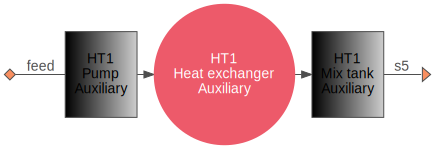

HeatedTank: HT1
ins...
[0] feed  
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow (kg/hr): Water  3.6e+03
outs...
[0] s5  
    phase: 'l', T: 310 K, P: 101325 Pa
    flow (kg/hr): Water  3.6e+03


Heated tank                                         Units      HT1
Electricity         Power                              kW    0.736
                    Cost                           USD/hr   0.0575
Low pressure steam  Duty                            kJ/hr 1.88e+05
                    Flow                          kmol/hr     4.86
                    Cost                           USD/hr     1.15
Purchase cost       Mix tank - Tank                   USD 3.07e+04
                    Pump - Pump                       USD 4.64e+03
                    Pump - Motor                      USD      273
                    Heat exchanger - Double pipe      USD 3.84e+03
Total purchase cost                                   USD 3.94e+04
Utility cost                                       USD/hr     1.21

In [21]:
class HeatedTank(bst.Unit):
    # Define names of auxiliary units
    auxiliary_unit_names = ('mix_tank', 'pump', 'heat_exchanger')
    
    def _init(self, T):
        pump = self.auxiliary(
            'pump', # name of auxiliary unit
            bst.Pump, # class of auxiliary unit
            ins=self.ins, # inlets to auxiliary unit (can be the same as parent unit)
        )
        heat_exchanger = self.auxiliary(
            'heat_exchanger', # name
            bst.HXutility, # class
            ins=pump.outlet, # outlet from pump is the inlet to heat exchanger
            T=T, #: additional arguments to HXutility (Temperature [K])
        )
        self.auxiliary(
            'mix_tank', # name
            bst.MixTank, # class
            ins=heat_exchanger.outlet, # connect
            outs=self.outs, # outlet from auxiliary unit (can be the same as parent unit)
        )
        
    def _run(self):
        # Run auxiliary unit operations internally
        self.pump._run()
        self.heat_exchanger._run()
        self.mix_tank._run()
        
    def _design(self):
        # Explicitly design and cost auxiliaries
        self.pump._design()
        self.heat_exchanger._design()
        self.mix_tank._design()
        
    def _cost(self):
        self.pump._cost()
        self.heat_exchanger._cost()
        self.mix_tank._cost()
    
feed = bst.Stream('feed', Water=200)
HT1 = HeatedTank('HT1', ins=feed, T=310)
HT1.simulate()
HT1.diagram(format='svg')
HT1.show()
HT1.results()

Note that BioSTEAM takes care of adding utilities and costs from auxiliary units to the parent unit. Auxiliary units are displayed by default in unit diagrams, but it is possible to supress this behavior by passing `auxiliaries=0`:

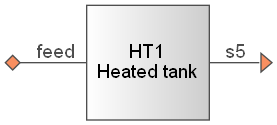

In [22]:
HT1.diagram(auxiliaries=0, format='png')

### References

<a id='References'></a>

1. Huang, H., Long, S., & Singh, V. (2016) "Techno-economic analysis of biodiesel and ethanol co-production from lipid-producing sugarcane" Biofuels, Bioproducts and Biorefining, 10(3), 299–315. https://doi.org/10.1002/bbb.1640

2. Seider, W. D., Lewin,  D. R., Seader, J. D., Widagdo, S., Gani, R., & Ng, M. K. (2017). Product and Process Design Principles. Wiley. Cost Accounting and Capital Cost Estimation (Chapter 16)

3. Humbird, D., Davis, R., Tao, L., Kinchin, C., Hsu, D., Aden, A., Dudgeon, D. (2011). Process Design and Economics for Biochemical Conversion of Lignocellulosic Biomass to Ethanol: Dilute-Acid Pretreatment and Enzymatic Hydrolysis of Corn Stover (No. NREL/TP-5100-47764, 1013269). https://doi.org/10.2172/1013269
